Dataset link on kaggle- https://www.kaggle.com/datasets/yasharjebraeily/drowsy-detection-dataset

###  **Pseudo Code**

* `Lenet-5` (https://www.analyticsvidhya.com/blog/2021/03/the-architecture-of-lenet-5/)
* `Custom model of my own`

**Data Loading and Preprocessing**

Converted data files into PyTorch ImageFolder Datasets that uses `torchvision.transforms.ToTensor()` to directly get image tensors of the form( tensor(color_channels ,height, width), label). After utilizing ToTensor() method ,we get rid of the duplicate grayscale color channels by accessing only the first index and changing the shape as `(3,48,48) ->(1,48,48)` for preprocessing before converting into DataLoaders using `torch.utils.data.DataLoaders`

**Lenet-5 Architecture**

Upon training Lenet-5 using the following hyperparameters , i got a test accuracy close to ***92%***
* *110* Epochs
* Learning Rate- *0.001*
* Regularization factor- *0.009* in the loss function

Training longer led to increase in Test losses and decrease in Test Accuracies while the train loss/accuracies kept improving, indicating overfitting, so i stopped at 110 epochs.

**Custom Model Architecture**

The Previous model might have been complex for our simple dataset so thsi model (model_1) consists of only two blocks:
`block_1 ->block_2`:

*block_1:`Conv2d -> ReLU -> MaxPool2d`
*block_2:`Conv2d -> Flatten -> Linear -> Linear`

By Printing out the shapes after each layer, we can find out what shape goes as in_features in the Linear layer.

Upon training using the following hyperparameters , i got a test accuracy close to ***85%***
* *110* Epochs
* lr-*0.000968*
* regularization factor-*0.099*

The model didn't learn much for initial 50 epochs, giving around ***50%*** Test accuracy but gradually picked up to ***87%*** in later epochs.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
paths=[]
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
paths[0]

'/kaggle/input/drowsy-detection-dataset/Drowsy_datset/test/DROWSY/815.png'

In [3]:
import torch
from torch import nn
from torch.nn.parallel import DataParallel
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import random
from timeit import default_timer as timer
from tqdm.auto import tqdm
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
import cv2
import pickle
import csv



## setup device agnostic code

In [4]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
test_data_paths=paths[:1483]
train_data_paths=paths[1483:]

In [6]:
test_data_paths[0],train_data_paths[0]

('/kaggle/input/drowsy-detection-dataset/Drowsy_datset/test/DROWSY/815.png',
 '/kaggle/input/drowsy-detection-dataset/Drowsy_datset/train/DROWSY/699.jpg_0.png')

In [7]:
len(train_data_paths)

5859

In [8]:
img=cv2.imread(train_data_paths[0])

In [9]:
np.reshape(img,(48,48,3))
img.shape

(48, 48, 3)

In [10]:
img[:,:,0].shape
img[:,:,0]

array([[ 1,  1,  0, ..., 25, 13, 25],
       [ 1,  1,  0, ..., 29, 26, 25],
       [ 1,  1,  0, ..., 30, 40, 29],
       ...,
       [ 2,  1,  1, ..., 14, 18, 28],
       [ 1,  1,  0, ..., 21, 22, 25],
       [ 1,  1,  1, ..., 23, 23, 23]], dtype=uint8)

In [11]:
img[:,:,1]==img[:,:,0],img[:,:,0]==img[:,:,2]
# every image has all 3 channels as grayscale which are duplicates of each other, so we consider only one of those channels.

(array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]),
 array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]))

## Convert into datasets

In [12]:
data_transform=transforms.ToTensor()

In [13]:
train_data=datasets.ImageFolder(root="/kaggle/input/drowsy-detection-dataset/Drowsy_datset/train",
                              transform=data_transform,
                              target_transform=None)
test_data=datasets.ImageFolder(root="/kaggle/input/drowsy-detection-dataset/Drowsy_datset/test",
                              transform=data_transform,
                              target_transform=None)
train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 5859
     Root location: /kaggle/input/drowsy-detection-dataset/Drowsy_datset/train
     StandardTransform
 Transform: ToTensor(),
 Dataset ImageFolder
     Number of datapoints: 1483
     Root location: /kaggle/input/drowsy-detection-dataset/Drowsy_datset/test
     StandardTransform
 Transform: ToTensor())

In [14]:
# we can access different properties like class names of the dataset by using torchvision.datasets.folder.ImageFolder
class_names=train_data.classes
class_names

['DROWSY', 'NATURAL']

In [15]:
type(train_data)

torchvision.datasets.folder.ImageFolder

In [16]:
# all 3 color channels are copies of the same ie. grayscale
torch.equal(train_data[0][0][0],train_data[0][0][1]) , torch.equal(train_data[0][0][2],train_data[0][0][1])

(True, True)

## Getting rid of extra duplicate dimentions (3,48,48) -> (1,48,48)

In [17]:
# train_data=[(img_1,label_1),(img_2,label_2).....] same format for test data aas well
train_data=[(train_data[i][0][0].unsqueeze(dim=0),train_data[i][1]) for i in range(len(train_data))]
test_data=[(test_data[i][0][0].unsqueeze(dim=0),test_data[i][1]) for i in range(len(test_data))]

## Visualising some samples from the dataset

In [18]:
samples=[]
labels=[]
for sample,label in random.sample(test_data,k=9):
    samples.append(sample)
    labels.append(label)

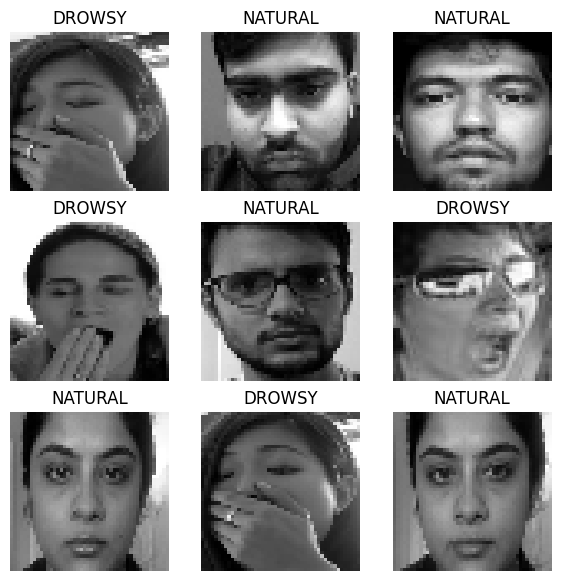

In [19]:
plt.figure(figsize=(7,7))
rows,cols=3,3
for i in range(1,rows*cols+1):
    plt.subplot(3,3,i)
    plt.imshow(samples[i-1].squeeze(),cmap="gray")
    plt.title(class_names[labels[i-1]])
    plt.axis(False)

## Converting datasets into iterable batched dataloaders

In [20]:
## Upon experimenting with batch_size 16,32,64,128 -> 32 gives best results keeping rest of the hyperparams same
train_dataloader=DataLoader(dataset=train_data,
                           batch_size=32, 
                           shuffle=True)
test_dataloader=DataLoader(dataset=test_data,
                          batch_size=32,
                          shuffle=True)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fe4f4584400>,
 <torch.utils.data.dataloader.DataLoader at 0x7fe4f4584c70>)

## Building CNN architecture : Lenet-5
https://www.analyticsvidhya.com/blog/2021/03/the-architecture-of-lenet-5/

In [21]:
class  DrowsyModelV0(nn.Module):
    def __init__(self,input_shape:int,
                 #hidden_units:int,
                 output_shape:int):
        super().__init__()
        
        self.block1=nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                     out_channels=6,
                     kernel_size=5,
                     padding=0,
                     stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2,
                        stride=2)
        )
        self.block2=nn.Sequential(
            nn.Conv2d(in_channels=6,
                     out_channels=16,
                     kernel_size=5,
                     padding=0,
                     stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2,
                        stride=2)
        )
        self.block3=nn.Sequential(
            nn.Conv2d(in_channels=16,
                     out_channels=120,
                     kernel_size=9,
                     padding=0,
                     stride=1),
            nn.Tanh(),
            nn.Flatten())
        self.classifier=nn.Sequential(
            nn.Linear(in_features=120,out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84,out_features=output_shape),
            
        )
        
    def forward(self,x):
        x=self.block1(x)
#         print(x.shape)
        x=self.block2(x)
#         print(x.shape)
        x=self.block3(x)
#         print(x.shape)
        x=self.classifier(x)
#         print(x.shape)
        return x
        
        

In [22]:
def accuracy_fn(y_true,y_preds):
    correct=torch.eq(y_true,y_preds).sum().item()
    acc=correct/len(y_true)*100
    return acc

In [23]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0=DrowsyModelV0(input_shape=1,output_shape=1).to(device)
model_0=DataParallel(model_0)# To ustilize both T4 GPUs at the same time

## Setting up loss function and optimizer

In [24]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model_0.parameters(),
                          lr=0.001,weight_decay=0.009)

## Training loop

In [25]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
train_losses=[]
test_losses=[]
train_accuracies=[]
test_accuracies=[]
epoch_list=[]
epochs=110
for epoch in range(epochs):
    epoch_list.append(epoch)
    train_loss,train_acc=0,0
    for X,y in train_dataloader:
        X,y=X.to(device),y.to(device)
        y_logits=model_0(X).squeeze()
        loss=loss_fn(y_logits,y.float())
        train_loss+=loss
        y_preds=torch.round(torch.sigmoid(y_logits))
        acc=accuracy_fn(y_true=y,
                       y_preds=y_preds)
        train_acc+=acc
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss/=len(train_dataloader)    
    train_losses.append(train_loss.item())
    
    train_acc/=len(train_dataloader)
    train_accuracies.append(train_acc)
    
    
    model_0.eval()
    test_loss,test_acc=0,0
    with torch.inference_mode():
        for X_test,y_test in test_dataloader:
            X_test,y_test=X_test.to(device),y_test.to(device)
            
            test_logits=model_0(X_test).squeeze()
            test_loss+=loss_fn(test_logits,y_test.float())
            
            test_preds=torch.round(torch.sigmoid(test_logits))
            test_acc+=accuracy_fn(y_true=y_test,
                                 y_preds=test_preds)
        
        test_loss/=len(test_dataloader)    
        test_losses.append(test_loss.item())

        test_acc/=len(test_dataloader)
        test_accuracies.append(test_acc)
    if epoch%10==0:
        print(f"Epoch:{epoch} | Train loss:{train_loss:.4f} | Train Accuracy:{train_acc:.2f}% | Test Loss:{test_loss:.4f} | Test Accuracy:{test_acc:.2f}%")

            
        

Epoch:0 | Train loss:0.6942 | Train Accuracy:47.87% | Test Loss:0.6901 | Test Accuracy:51.22%
Epoch:10 | Train loss:0.6788 | Train Accuracy:54.50% | Test Loss:0.6827 | Test Accuracy:51.30%
Epoch:20 | Train loss:0.6567 | Train Accuracy:66.32% | Test Loss:0.6559 | Test Accuracy:66.13%
Epoch:30 | Train loss:0.5963 | Train Accuracy:74.62% | Test Loss:0.5763 | Test Accuracy:78.93%
Epoch:40 | Train loss:0.5029 | Train Accuracy:76.66% | Test Loss:0.4458 | Test Accuracy:81.53%
Epoch:50 | Train loss:0.4414 | Train Accuracy:79.37% | Test Loss:0.3639 | Test Accuracy:82.92%
Epoch:60 | Train loss:0.4035 | Train Accuracy:81.83% | Test Loss:0.2962 | Test Accuracy:86.77%
Epoch:70 | Train loss:0.3794 | Train Accuracy:82.72% | Test Loss:0.2493 | Test Accuracy:91.29%
Epoch:80 | Train loss:0.3588 | Train Accuracy:84.36% | Test Loss:0.2275 | Test Accuracy:91.37%
Epoch:90 | Train loss:0.3422 | Train Accuracy:85.31% | Test Loss:0.2054 | Test Accuracy:92.43%
Epoch:100 | Train loss:0.3282 | Train Accuracy:86.2

## visualizing accuracy/loss curves

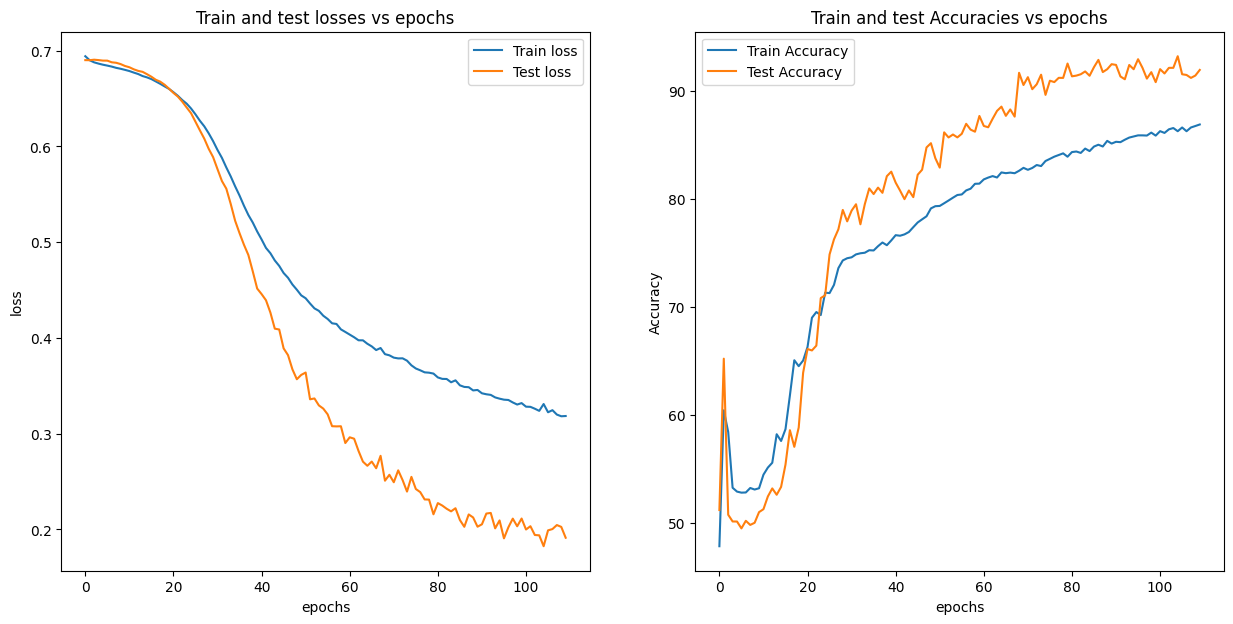

In [26]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(epoch_list,train_losses,label="Train loss")
plt.plot(epoch_list,test_losses,label="Test loss")
plt.title("Train and test losses vs epochs")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch_list,train_accuracies,label="Train Accuracy")
plt.plot(epoch_list,test_accuracies,label="Test Accuracy")
plt.title("Train and test Accuracies vs epochs")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend()



## Evaluating model_0

In [27]:
model_0.eval()
pred_labels_0=[]
test_loss,test_acc=0,0
with torch.inference_mode():
    for X_test,y_test in test_dataloader:
        X_test,y_test=X_test.to(device),y_test.to(device)

        test_logits=model_0(X_test).squeeze()
        test_loss+=loss_fn(test_logits,y_test.float())

        test_preds=torch.round(torch.sigmoid(test_logits))
        pred_labels_0.extend(test_preds)
        test_acc+=accuracy_fn(y_true=y_test,
                             y_preds=test_preds)

    test_loss/=len(test_dataloader)    
    test_acc/=len(test_dataloader)
    
    print(f"Test Loss:{test_loss:.4f} | Test Accuracy:{test_acc:.2f}%")

Test Loss:0.1907 | Test Accuracy:91.96%


In [28]:
pred_labels_0=[int(i.item()) for i in pred_labels_0]

## Saving model_0 weights(state_dict)

In [29]:
model_0_state_dict=model_0.state_dict()
path_0="/kaggle/working/model_0_weights.pkl"

with open(path_0,'wb') as f:
    pickle.dump(model_0_state_dict,f)

## Saving model_0 predictions

In [30]:
with open("model_0_preds.csv",'w') as file:
    wobj=csv.writer(file)
    for i in pred_labels_0:
        wobj.writerow([i])

## Making custom model DrowsyModelV1

In [31]:
class DrowsyModelV1(nn.Module):
    def __init__(self,input_shape,output_shape):
        super().__init__()
        
        self.block1=nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                     out_channels=16,
                     kernel_size=5,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,
                         stride=2)
        )

        self.block2=nn.Sequential(
            nn.Conv2d(in_channels=16,
                     out_channels=5,
                     kernel_size=4,
                     padding=1,
                     stride=2),
            nn.Flatten(),
            nn.Linear(in_features=5*11*11,
                     out_features=64),
            nn.Linear(in_features=64,out_features=output_shape)
        )
    def forward(self,x):
        x=self.block1(x)
#         print(x.shape)
        x=self.block2(x)
#         print(x.shape)
        return x

In [32]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_1=DrowsyModelV1(input_shape=1,output_shape=1).to(device)
model_1=DataParallel(model_1)

## setting up loss function and optimizer

In [33]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model_1.parameters(),
                          lr=0.000968,weight_decay=0.099)

## Training loop

In [34]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
train_losses=[]
test_losses=[]
train_accuracies=[]
test_accuracies=[]
epoch_list=[]
epochs=110
for epoch in range(epochs):
    epoch_list.append(epoch)
    train_loss,train_acc=0,0
    for X,y in train_dataloader:
        X,y=X.to(device),y.to(device)
        y_logits=model_1(X).squeeze()
        loss=loss_fn(y_logits,y.float())
        train_loss+=loss
        y_preds=torch.round(torch.sigmoid(y_logits))
        acc=accuracy_fn(y_true=y,
                       y_preds=y_preds)
        train_acc+=acc
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss/=len(train_dataloader)    
    train_losses.append(train_loss.item())
    
    train_acc/=len(train_dataloader)
    train_accuracies.append(train_acc)
    
    
    model_1.eval()
    test_loss,test_acc=0,0
    with torch.inference_mode():
        for X_test,y_test in test_dataloader:
            X_test,y_test=X_test.to(device),y_test.to(device)
            
            test_logits=model_1(X_test).squeeze()
            test_loss+=loss_fn(test_logits,y_test.float())
            
            test_preds=torch.round(torch.sigmoid(test_logits))
            test_acc+=accuracy_fn(y_true=y_test,
                                 y_preds=test_preds)
        
        test_loss/=len(test_dataloader)    
        test_losses.append(test_loss.item())

        test_acc/=len(test_dataloader)
        test_accuracies.append(test_acc)
    if epoch%10==0:
        print(f"Epoch:{epoch} | Train loss:{train_loss:.4f} | Train Accuracy:{train_acc:.2f}% | Test Loss:{test_loss:.4f} | Test Accuracy:{test_acc:.2f}%")

            
                    
        

Epoch:0 | Train loss:0.6917 | Train Accuracy:59.60% | Test Loss:0.6908 | Test Accuracy:56.21%
Epoch:10 | Train loss:0.6884 | Train Accuracy:51.79% | Test Loss:0.6910 | Test Accuracy:48.91%
Epoch:20 | Train loss:0.6866 | Train Accuracy:51.96% | Test Loss:0.6906 | Test Accuracy:48.65%
Epoch:30 | Train loss:0.6850 | Train Accuracy:52.12% | Test Loss:0.6893 | Test Accuracy:48.78%
Epoch:40 | Train loss:0.6822 | Train Accuracy:53.11% | Test Loss:0.6874 | Test Accuracy:49.11%
Epoch:50 | Train loss:0.6776 | Train Accuracy:54.10% | Test Loss:0.6837 | Test Accuracy:49.78%
Epoch:60 | Train loss:0.6657 | Train Accuracy:59.32% | Test Loss:0.6706 | Test Accuracy:56.73%
Epoch:70 | Train loss:0.6198 | Train Accuracy:73.26% | Test Loss:0.6125 | Test Accuracy:76.80%
Epoch:80 | Train loss:0.5126 | Train Accuracy:75.63% | Test Loss:0.4848 | Test Accuracy:74.49%
Epoch:90 | Train loss:0.4542 | Train Accuracy:79.70% | Test Loss:0.4105 | Test Accuracy:77.80%
Epoch:100 | Train loss:0.4284 | Train Accuracy:80.6

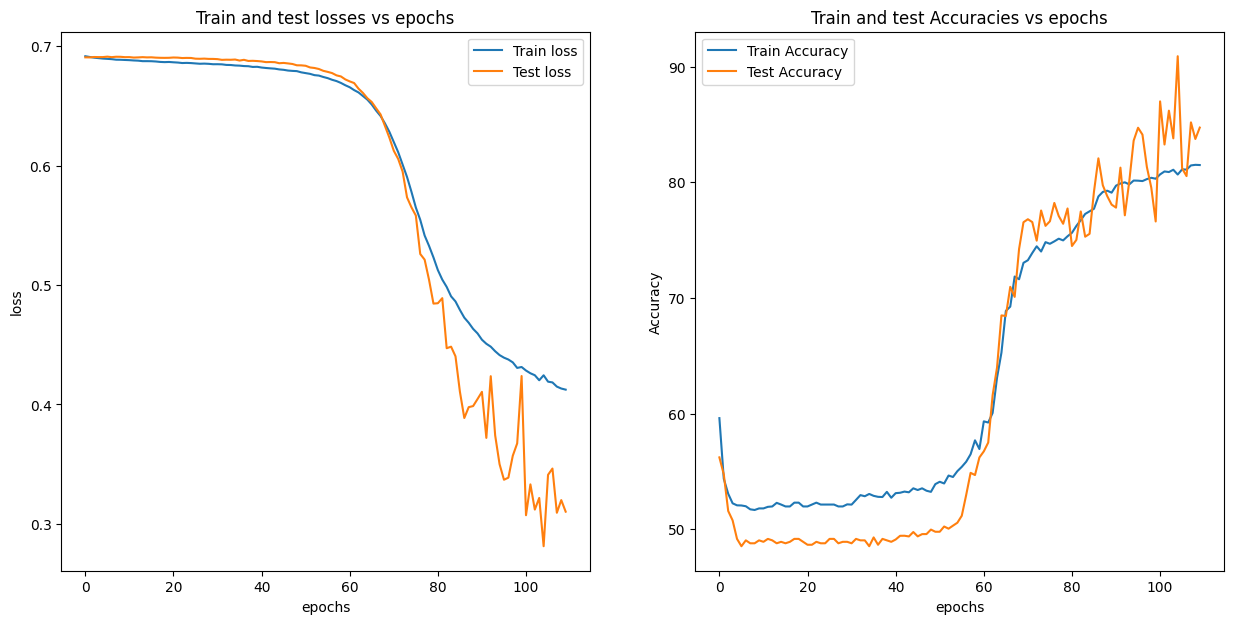

In [35]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(epoch_list,train_losses,label="Train loss")
plt.plot(epoch_list,test_losses,label="Test loss")
plt.title("Train and test losses vs epochs")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch_list,train_accuracies,label="Train Accuracy")
plt.plot(epoch_list,test_accuracies,label="Test Accuracy")
plt.title("Train and test Accuracies vs epochs")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend()



## Evaluating model_1

In [36]:
model_1.eval()
pred_labels_1=[]
test_loss,test_acc=0,0
with torch.inference_mode():
    for X_test,y_test in test_dataloader:
        X_test,y_test=X_test.to(device),y_test.to(device)

        test_logits=model_1(X_test).squeeze()
        test_loss+=loss_fn(test_logits,y_test.float())

        test_preds=torch.round(torch.sigmoid(test_logits))
        pred_labels_1.extend(test_preds)
        test_acc+=accuracy_fn(y_true=y_test,
                             y_preds=test_preds)

    test_loss/=len(test_dataloader)    
    test_acc/=len(test_dataloader)
    print(f"Test Loss:{test_loss:.4f} | Test Accuracy:{test_acc:.2f}%")

Test Loss:0.3088 | Test Accuracy:85.11%


In [37]:
pred_labels_1=[int(i.item()) for i in pred_labels_1]

## Saving model_1 weights (state_dict)


In [38]:
model_1_state_dict=model_0.state_dict()
path_1="/kaggle/working/model_1_weights.pkl"

with open(path_1,'wb') as f:
    pickle.dump(model_1_state_dict,f)

## Saving model_1 predictions

In [39]:
with open("model_1_preds.csv",'w') as file:
    wobj=csv.writer(file)
    for i in pred_labels_1:
        wobj.writerow([i])